# Conformalized Survival Regression

In this notebook we'll explore survival prediction in a classical setting, survival prediction under incomplete censoring times, and our proposed remedy for incomplete censoring times, using our novel technique.

First we need a baseline. In the classical case of Type I censoring, for every patient there is a triplet $(X,C,T)$, of which we have access to $(X,\tilde{T}=C\wedge T, T)$.
We'll use the same random generation process as Candes et. al.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
from sklearn.dummy import DummyRegressor



In [ ]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
X_multi = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, 100))
# C_uni = X_uni/2
C_uni = np.random.exponential(10, size=n_samples) * X_uni
# C_uni = np.random.exponential(10, size=n_samples)
C_multi = np.random.exponential(10, size=n_samples) * (X_multi[:,0] + 1)
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C_uni), np.minimum(T_uni_hetero, C_uni))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C_uni)

mu_multi = np.log(2) + 1 + 0.55 * (X_multi[:,0]**2 + X_multi[:,2] * X_multi[:,4])
sd_multi_homo = 1
sd_multi_hetero = np.abs(X_multi[:,9]) + 1

T_multi_homo = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_homo, size=n_samples))
T_tilde_multi_homo = Surv.from_arrays((T_multi_homo < C_multi), np.minimum(T_multi_homo, C_multi))
T_multi_hetero = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_hetero, size=n_samples))
T_tilde_multi_hetero = Surv.from_arrays((T_multi_hetero < C_multi), np.minimum(T_multi_hetero, C_multi))

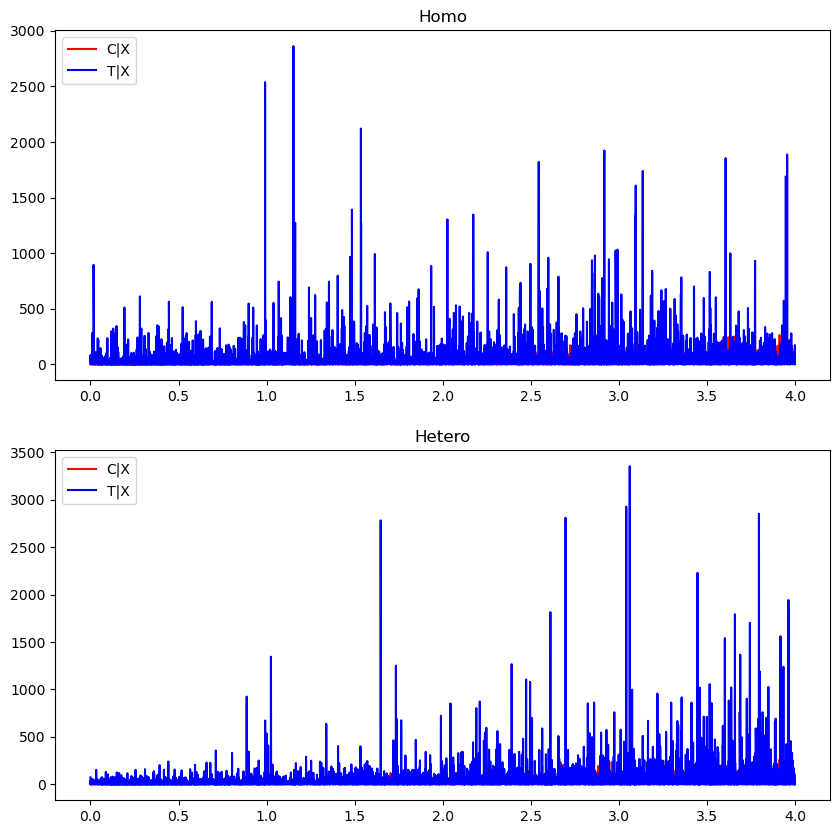

In [ ]:
data_uncensored = [
    (X_uni, C_uni, T_uni_homo),
    (X_uni, C_uni, T_uni_hetero)
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, c, t = data_uncensored[i]
    axs[i].plot(x, c, color="red", label='C|X', )
    axs[i].plot(x, t, color="blue", label='T|X')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

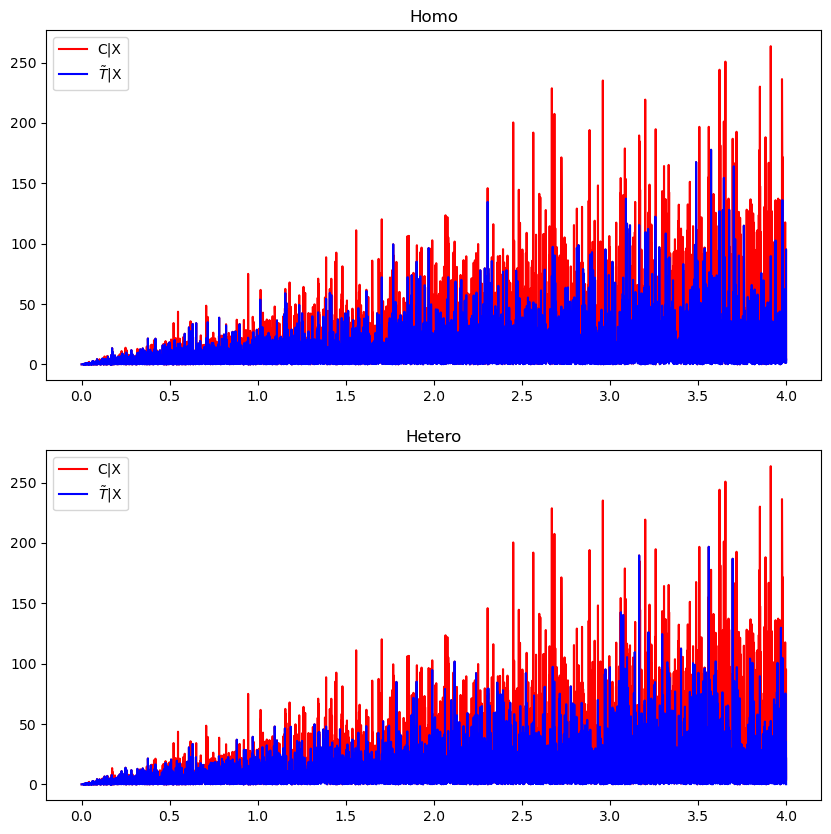

In [ ]:
data_censored = [
    (X_uni, C_uni, np.minimum(T_uni_homo, C_uni)),
    (X_uni, C_uni, np.minimum(T_uni_hetero, C_uni))
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, c, t = data_censored[i]
    axs[i].plot(x, c, color="red", label='C|X', )
    axs[i].plot(x, t, color="blue", label=r'$\tilde{T}$|X')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

In [16]:
alpha = 0.1
betas = np.array([beta/10.0 for beta in range(1, 10, 1)])
X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, C_uni_homo_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C_uni, T_uni_homo)
X_uni_het_train, X_uni_het_test, C_uni_het_train, C_uni_het_test, T_uni_het_train, T_uni_het_test = train_test_split(X_uni, C_uni, T_uni_hetero)
X_multi_homo_train, X_multi_homo_test, C_multi_homo_train, C_multi_homo_test, T_multi_homo_train, T_multi_homo_test = train_test_split(X_multi, C_multi, T_multi_homo)
X_multi_het_train, X_multi_het_test, C_multi_het_train, C_multi_het_test, T_multi_het_train, T_multi_het_test = train_test_split(X_multi, C_multi, T_multi_hetero)

# Weighted Conformal

In [ ]:
def non_conformity(y, y_hat):
    scores = np.append(y_hat - y['time'], np.inf)
    # print(f"actual y: {y['time']}")
    # print(f"y_hat: {y_hat}")
    scores.sort()
    return scores

def estimate_weights(betas, C_hat, c_0):
    # Step 1: Find where C_hat > c_0
    greater_than_c0 = C_hat > c_0

    # Step 2: Find the index of the first True value in each row
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)

    # Step 3: Select the corresponding betas
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

def oracle_weights(betas, X_cal, lamb, c_0):
    exp_quantiles = np.array([- np.log(1-b)/lamb for b in betas]).reshape(1,-1)
    greater_than_c0 = (X_cal * exp_quantiles) > c_0
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

# print(estimate_weights(np.array([0.1, 0.5 ,0.9]), np.array([[1, 2 ,3], [1, 3 ,5]]), 2.5)) # [10.  2.]

In [24]:
def cfsurv_c0(X_train, X_test, C_train, T_train, T_test, c_0, alpha, delta_death=np.inf):
    # split the train data into training and calibration
    X_train, X_test, C_train, T_train, T_test = X_train.copy(), X_test.copy(), C_train.copy(), T_train.copy(), T_test.copy()
    T_tilde_train = Surv.from_arrays((T_train < C_train), np.minimum(T_train, C_train))
    C_train = Surv.from_arrays((C_train < T_train + delta_death), np.minimum(C_train, T_train + delta_death))
    T_tilde_train['time'] = np.minimum(T_tilde_train['time'], c_0)
    if len(X_train.shape) == 1 and len(X_test.shape) == 1:
        X_train = X_train.reshape(-1,1)
        X_test = X_test.reshape(-1,1)
    X_train, X_cal, C_train, C_cal, T_tilde_train, T_tilde_cal = train_test_split(X_train, C_train, T_tilde_train, train_size=X_train.shape[0]//2)
    
    # keep only data where C>=c_0
    T_tilde_cal, X_cal = T_tilde_cal[C_cal['time'] >= c_0].copy(), X_cal[C_cal['time'] >= c_0]
     
    # train a regression model on T: q_hat(x)
    T_est = GradientBoostingSurvivalAnalysis(loss="pinball", beta=1-alpha, learning_rate=1.0, max_depth=1, random_state=0)
    T_est.fit(X_train, T_tilde_train)
    
    # compute conformity score for each point in the calibration set
    T_cal_hat = T_est.predict(X_cal)
    scores = non_conformity(T_tilde_cal, T_cal_hat)
    
    # estimate the weight for each point in the calibration set
    betas = np.array([beta/100.0 for beta in range(1, 100, 1)])
    C_est = [GradientBoostingSurvivalAnalysis(loss="pinball", beta=b, learning_rate=0.1, max_depth=1, random_state=0) for b in betas]
    C_hat_cal = []
    C_hat_test = []
    for est in C_est:
        est.fit(X_train, C_train)
        C_hat_cal.append(est.predict(X_cal))
        C_hat_test.append(est.predict(X_test))
    
    C_hat_cal = np.transpose(np.array(C_hat_cal))
    C_hat_test = np.transpose(np.array(C_hat_test))
    
    w_cal = estimate_weights(betas, C_hat_cal, c_0)
 
    # compute the weights for the test data
    w_test = estimate_weights(betas, C_hat_test, c_0)

    # compute propensity scores
    p_test = (w_test / (w_cal.sum() + w_test)).reshape(-1,1) # vector of length len(w_test)
    p_cal = w_cal.reshape(1,-1) / (w_cal.sum() + w_test.reshape(-1,1)) # size of (w_test, w_cal)
    p = np.concatenate([p_cal, p_test], axis=1)
    np.testing.assert_almost_equal(p[0].sum(),1, decimal=10) # f'propensity weights don\'t sum to 1, sum: {p[0].sum()}'

    # compute weighted quantiles for each test point
    cumulative_weights = np.cumsum(p, axis=1)
    np.testing.assert_almost_equal(p[-1].sum(), 1, decimal=10) # 'wrong cumsum axis'
    quantile_indices = np.argmax(cumulative_weights >= (1-alpha), axis=1)
    quantile_values = scores[quantile_indices]

    # compute LPB
    lpb = np.minimum(T_est.predict(X_test) - quantile_values, c_0)
    emp_coverage = (lpb <= np.minimum(T_test, c_0)) # coverage for min(T,c_0)
    emp_coverage = emp_coverage.sum()/len(emp_coverage)
    emp_coverage_T = (lpb <= T_test) # coverage for T

    return lpb, emp_coverage, emp_coverage_T, scores

# Coverage Experiments

In [15]:
lpb, emp_coverage, scores = cfsurv_c0(X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, T_uni_homo_train, T_uni_homo_test, 10, 0.1)
print(f"coverage is {emp_coverage}")
print(f"LPBs are {lpb}")

coverage is 0.7564
LPBs are [-inf -inf -inf ... -inf  10.  10.]


In [18]:
lpb, emp_coverage, scores = cfsurv_c0(X_uni_het_train, X_uni_het_test, C_uni_het_train, T_uni_het_train, T_uni_het_test, 10, 0.1)
print(f"coverage is {emp_coverage}")
print(f"LPBs are {lpb}")

coverage is 0.91
LPBs are [1.94989024 1.94989024 1.94989024 ... 1.94989024 1.94989024 2.35385884]


7.926138736863805


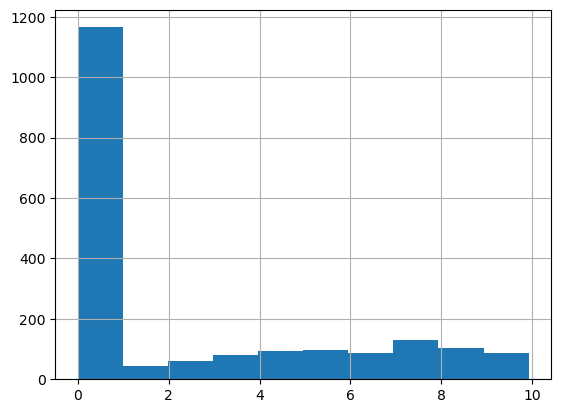

In [ ]:
pd.Series(scores[:-1]).hist()
print(pd.Series(scores).quantile(0.9))

In [11]:
# find c_0 for uni homo that gives the closest coverage to 1-alpha
c_0_vals = np.array(np.logspace(0,2,10))
coverage_homo = []
for c_0 in c_0_vals:
    coverage_c_0 = 0
    for i in range(5):
        lpb, emp_coverage, scores = cfsurv_c0(X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, T_uni_homo_train, T_uni_homo_test, c_0, 0.1)
        coverage_c_0 += emp_coverage
    coverage_homo.append(coverage_c_0/5)

KeyboardInterrupt: 

In [20]:
# find c_0 for uni homo that gives the closest coverage to 1-alpha
c_0_vals = np.array(np.logspace(0,2,10))
coverage_het = []
for c_0 in c_0_vals:
    coverage_c_0 = 0
    for i in range(5):
        lpb, emp_coverage, emp_coverage_T, scores = cfsurv_c0(X_uni_het_train, X_uni_het_test, C_uni_het_train, T_uni_het_train, T_uni_het_test, c_0, 0.1)
        coverage_c_0 += emp_coverage
    coverage_het.append(coverage_c_0/5)

In [21]:
coverage_het

[0.96968,
 0.9656,
 0.9103200000000001,
 0.9122399999999999,
 0.9096,
 0.86144,
 0.8779999999999999,
 0.9523199999999999,
 0.96,
 0.9612]

In [23]:
c_0_opt_uni = 12.91549665
c_0_opt_het = 21.5443469


In [14]:
c_0_vals = np.array(np.logspace(0,2,10))
coverage = np.ndarray((8,10))
c_o_indexes = range(10)
death_delta = np.array(np.logspace(0.5,2,10))
for i in c_o_indexes:
    for j in death_delta:
        coverage_c_0 = 0
        for z in range(5):
            lpb, emp_coverage, scores = cfsurv_c0_death(X_uni_train, X_uni_test, C_train, T_uni_homo_train, T_uni_homo_test, c_0_vals[i], 0.1, j)
            coverage_c_0 += emp_coverage
        coverage[j,i] = coverage_c_0/5

KeyboardInterrupt: 

In [ ]:
coverage[:,5] # for optimal c_0 for former data

array([0.49584, 0.5064 , 0.53296, 0.5544 , 0.58328, 0.6076 , 0.63624,
       0.67312])

In [ ]:
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()

C_uni = np.random.exponential(10, size=n_samples) * X_uni
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))

Generate new Data for experiments:

In [30]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
X_multi = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, 100))
C_uni = np.random.exponential(10, size=n_samples) * X_uni
C_multi = np.random.exponential(10, size=n_samples) * (X_multi[:,0] + 1)
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C_uni), np.minimum(T_uni_hetero, C_uni))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C_uni)

mu_multi = np.log(2) + 1 + 0.55 * (X_multi[:,0]**2 + X_multi[:,2] * X_multi[:,4])
sd_multi_homo = 1
sd_multi_hetero = np.abs(X_multi[:,9]) + 1

T_multi_homo = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_homo, size=n_samples))
T_tilde_multi_homo = Surv.from_arrays((T_multi_homo < C_multi), np.minimum(T_multi_homo, C_multi))
T_multi_hetero = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_hetero, size=n_samples))
T_tilde_multi_hetero = Surv.from_arrays((T_multi_hetero < C_multi), np.minimum(T_multi_hetero, C_multi))

In [31]:
X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, C_uni_homo_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C_uni, T_uni_homo)
X_uni_het_train, X_uni_het_test, C_uni_het_train, C_uni_het_test, T_uni_het_train, T_uni_het_test = train_test_split(X_uni, C_uni, T_uni_hetero)
X_multi_homo_train, X_multi_homo_test, C_multi_homo_train, C_multi_homo_test, T_multi_homo_train, T_multi_homo_test = train_test_split(X_multi, C_multi, T_multi_homo)
X_multi_het_train, X_multi_het_test, C_multi_het_train, C_multi_het_test, T_multi_het_train, T_multi_het_test = train_test_split(X_multi, C_multi, T_multi_hetero)

In [32]:
coverage_uni_homo = {}
coverage_uni_het = {}
coverage_T_uni_homo = {}
coverage_T_uni_het = {}

death_delta = np.append(np.array(np.logspace(0.5,2,10)), np.inf)
repeat_range = range(10)

for d in death_delta:
    coverage_uni_homo[d] = []
    coverage_uni_het[d] = []
    coverage_T_uni_homo[d] = []
    coverage_T_uni_het[d] = []
    for i in repeat_range:
        lpb_homo, emp_coverage_homo, emp_coverage_T_homo, scores_homo = cfsurv_c0(X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, T_uni_homo_train, T_uni_homo_test, c_0_opt_uni, 0.1, d)
        lpb_het, emp_coverage_het, emp_coverage_T_het, scores_het = cfsurv_c0(X_uni_het_train, X_uni_het_test, C_uni_het_train, T_uni_het_train, T_uni_het_test, c_0_opt_het, 0.1, d)
        coverage_uni_homo[d].append(emp_coverage_homo)
        coverage_uni_het[d].append(emp_coverage_het)
        coverage_T_uni_homo[d].append(emp_coverage_T_homo)
        coverage_T_uni_het[d].append(emp_coverage_T_het)

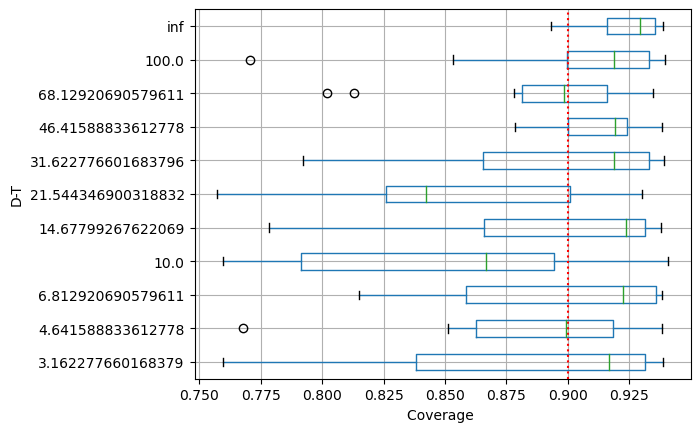

In [29]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in coverage_uni_het.items() ]))
df = df.reindex(sorted(df.columns, key=float), axis=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Create the boxplot
bp = df.boxplot(vert=False)

ax.set_xlabel('Coverage ')
ax.set_ylabel('D-T')

# Plot a vertical red dotted line
plt.axvline(x=0.9, color='red', linestyle='dotted')

# Display the plot
plt.show()